import boto3
import bson
from bson.json_util import dumps, loads
import json
import os
from PIL import Image
import PIL
from io import BytesIO
import pandas as pd
import geopandas
import numpy as np
import feather
import h5py
import gc

pd.options.display.max_columns=999
pd.options.display.max_rows = 999

# import helper 
import sys
sys.path.append("/Users/xszpo/Google Drive/DataScience/Projects/201907_xFlat_AWS_Scrapy")
import helpers

# run scrapy settings
%run /Users/xszpo/Google\ Drive/DataScience/Projects/201907_xFlat_AWS_Scrapy/scraper/settings.py

LOCAL_DATA_PATH

# Load raw data

In [4]:
import os
import gc
from sklearn.model_selection import train_test_split
import numpy as np 
import scipy 
import keras 
import pandas as pd
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import compress
from itertools import chain
import unidecode
import re
import codecs
import geopandas
import json
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from itertools import compress

from PIL import Image as IMG
import cv2

import seaborn as sns
%matplotlib notebook

import sys
sys.path.append("/Users/xszpo/Google Drive/DataScience/Projects/201907_xFlat_AWS_Scrapy/app_webscr_otodom")
import helpers

# run scrapy settings
%run /Users/xszpo/Google\ Drive/DataScience/Projects/201907_xFlat_AWS_Scrapy/app_webscr_otodom/scraper/settings.py

pd.options.display.max_columns=999
pd.options.display.max_rows = 999

**Generator assumption**

**ID** - string that identifies a given sample of the dataset.     
**partition** -  dictionary with train/test split:    
    - in partition['train'] a list of training IDs
    - in partition['validation'] a list of validation IDs   
**labels** - dictionary where for each ID of the dataset, the associated label is given by labels[ID]

In [5]:
ID_list = [i[:-5] for i in os.listdir(LOCAL_DATA_PATH) if i.endswith(".bson")]

In [6]:
len(ID_list)

19892

    @staticmethod
    def read_bus_gpd(path, file, X = "X", Y="Y"):
        with codecs.open(os.path.join(path,file), "r", "utf-8") as file:
            bus_stops_json = json.loads(file.read())
        bus_stops_df = pd.DataFrame(bus_stops_json)
        bus_stops_gdf = geopandas.GeoDataFrame(
            bus_stops_df, geometry=geopandas.points_from_xy(bus_stops_df[X], bus_stops_df[Y]))
        return bus_stops_gdf

In [7]:
def read_bus_gpd(path, file, X = "X", Y="Y"):
    with codecs.open(os.path.join(path,file), "r", "utf-8") as file:
        bus_stops_json = json.loads(file.read())
    bus_stops_df = pd.DataFrame(bus_stops_json)
    bus_stops_gdf = geopandas.GeoDataFrame(
        bus_stops_df, geometry=geopandas.points_from_xy(bus_stops_df[X], bus_stops_df[Y]))
    return bus_stops_gdf


In [8]:
def load_raw_data(file_name_list, file_path):
    
    _dict = {}
    
    for name in file_name_list:
        # LOAD DATA
        _tmp = helpers.scraper.read_bson_local(file_path, name+".bson")
        _dict[name] = helpers.scraper.dict_except(_tmp,['gallery'])
        # red only the first image
        _dict[name]['img_gallery_strimg'] = _dict[name]['img_gallery_strimg'][:1]
    gc.collect()
    return _dict
    

In [9]:
class PassThroughOrReplace(BaseEstimator, TransformerMixin):
    """
    Just pass data throught, !Rememeber to reset DF index before:
    * It will replace text or numeric values if dictionary is provided
      ex. replace_dict = {'column name':{'old value':'new value'}}
    * It will fill na if fillna is True, text with 'novalue', numeric with mean
    """

    def __init__(self, replace_dict=None, fillna=False, **kwargs):
        self.replace_dict = replace_dict
        self.fillna = fillna
        self.kwargs = kwargs

    def fit(self, x, y=None):

        new_x = x.copy()

        if type(new_x) == pd.core.frame.DataFrame:

            self.f_category = list(new_x.select_dtypes(
                include=['object']).columns)
            self.f_numeric = list(new_x.select_dtypes(
                exclude=['object']).columns)
            self.f_date = list(new_x.select_dtypes(
                    include=['datetime64[ns]']).columns)

        if type(new_x) == pd.core.series.Series:

            self.f_category = list(new_x.to_frame().select_dtypes(
                include=['object']).columns)
            self.f_numeric = list(new_x.to_frame().select_dtypes(
                exclude=['object']).columns)
            self.f_date = list(new_x.to_frame().select_dtypes(
                include=['datetime64[ns]']).columns)

        if self.replace_dict:
            if type(new_x) == pd.core.frame.DataFrame:
                new_x.replace(self.replace_dict, inplace=True)

            if type(new_x) == pd.core.series.Series:
                new_x = new_x.to_frame().replace(self.replace_dict).iloc[:, 0]

        if type(new_x) == pd.core.frame.DataFrame:
            self.columnNames = new_x.columns
            self.means = pd.DataFrame.from_dict(
                {"column": new_x[self.f_numeric].mean().index,
                "mean": new_x[self.f_numeric].mean()}).to_dict(orient='index')

        if type(new_x) == pd.core.series.Series:
            self.columnNames = [new_x.name]
            self.means = {new_x.name: {"column": new_x.name, 
                                        "mean": new_x.mean()}}

        return self

    def get_feature_names(self):
        if hasattr(self, "columnNames"):
            return self.columnNames
        else:
            return None

    def transform(self, x):

        new_x = x.copy()

        if self.replace_dict:
            if type(new_x) == pd.core.frame.DataFrame:
                new_x.replace(self.replace_dict, inplace=True)

            if type(new_x) == pd.core.series.Series:
                new_x = new_x.to_frame().replace(self.replace_dict).iloc[:, 0]

        if self.fillna:
            if len(self.f_category) > 0:
                #new_x.replace({'': np.nan}, inplace=True)
                new_x.fillna('novalue', inplace=True)

            if len(self.f_numeric) > 0 and type(new_x) == pd.core.frame.DataFrame:
                for col in self.f_numeric:
                    new_x[col] = new_x[col].fillna(self.means[col]["mean"])

            if len(self.f_numeric) > 0 and type(new_x) == pd.core.series.Series:
                new_x = new_x.fillna(self.means[x.name]["mean"]).to_frame()

        return new_x

In [10]:
#https://medium.com/machine-learning-world/feature-extraction-and-similar-image-search-with-opencv-for-newbies-3c59796bf774
#https://www.kaggle.com/shivamb/ideas-for-image-features-and-image-quality

from collections import defaultdict
import operator
from skimage import feature
from scipy.stats import itemfreq


def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

def perform_color_analysis(im, flag):
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        return None
        
    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None
    
def get_dominant_color(img):
    path = images_path + img 
    img = cv2.imread(path)
    arr = np.float32(img)
    pixels = arr.reshape((-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(img.shape)

    dominant_color = palette[np.argmax(itemfreq(labels)[:, -1])]
    return dominant_color

def get_average_dominant_color(img):
    
    #average
    img = np.array(img) 
    average_color = [img[:, :, i].mean() for i in range(img.shape[-1])]
    
    return average_color[0],average_color[1],average_color[2] 
    
def get_blurrness_score(image):
    image = np.array(image) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return int(fm)

def extract_features(img, vector_size=32):
    image=np.array(img) 
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc


In [11]:
def transform_json_df(raw_json, partition = None):
    
    
    if partition:
        _tmp_list_train = []
        _tmp_list_validation = []
        _tmp_list_test = []
        file_list = partition['train']+partition['validation']+partition['test']
    else:
        _tmp_list = []
        file_list = list(raw_json.keys())
    
    for i,file in enumerate(file_list):
        
        # LOAD DATA
        _tmp = raw_json[file]
        _tmp = helpers.scraper.dict_except(_tmp,['gallery'])
        
        # PUT DATA INTO COLUMNS
        _tmp['_id'] = file
        _tmp['GC_latitude'] = np.float32(_tmp['geo_coordinates']['latitude'])
        _tmp['GC_longitude'] = np.float32(_tmp['geo_coordinates']['longitude'])
        _tmp['GC_boundingbox'] = _tmp['geo_address_coordin']['@boundingbox']
        _tmp['GC_addr_house_number'] = _tmp['geo_address_text']['house_number'] if 'house_number' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_road'] = _tmp['geo_address_text']['road'] if 'road' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_neighbourhood'] = _tmp['geo_address_text']['neighbourhood'] if 'neighbourhood' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_suburb'] = _tmp['geo_address_text']['suburb'] if 'suburb' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_city'] = _tmp['geo_address_text']['city'] if 'city' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_county'] = _tmp['geo_address_text']['county'] if 'country' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_state'] = _tmp['geo_address_text']['state'] if 'state' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_postcode'] = _tmp['geo_address_text']['postcode'] if 'postcode' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_country'] = _tmp['geo_address_text']['country'] if 'country' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_country_code'] = _tmp['geo_address_text']['country_code'] if 'country_code' in _tmp['geo_address_text'] else None
        _tmp['additional_info'] =_tmp['additional_info'].split("|")
        _ = _tmp.pop('geo_coordinates')
        _ = _tmp.pop('geo_address_coordin') 
        _ = _tmp.pop('price_per_square')

        
        # MODIFY DATA
        _tmp['flat_size'] = helpers.scraper.digits_from_str(_tmp['flat_size']) if _tmp['flat_size'] is not None else None
        _tmp['price'] = helpers.scraper.digits_from_str(_tmp['price']) if _tmp['price'] is not None else None
        _tmp['price_m2'] = helpers.scraper.digits_from_str(_tmp['price_m2']) if _tmp['price_m2'] is not None else None
        _tmp['rooms'] = int(helpers.scraper.digits_from_str(_tmp['rooms'])) if _tmp['rooms'] is not None else None
        _tmp['floor_attic'] = 1 if _tmp['floor']=='poddasze' else 0
        _tmp['floor_basement'] = 1 if _tmp['floor']=='suterena' else 0
        _tmp['floor'] = np.float32(helpers.scraper.convert_floor(_tmp['floor'])) if isinstance(_tmp['floor'], (str)) else None
        _tmp['number_of_floors'] = np.float32(_tmp['number_of_floors']) if isinstance(_tmp['number_of_floors'], (str)) else None
        _tmp['year_of_building'] = np.float32(_tmp['year_of_building']) if isinstance(_tmp['year_of_building'], (str)) else None
        _tmp['rent_price'] = helpers.scraper.digits_from_str(_tmp['rent_price']) if _tmp['rent_price'] is not None else None
        
        # image
        #https://www.kaggle.com/shivamb/ideas-for-image-features-and-image-quality
        
        #img_1 = helpers.scraper.open_img_from_str(_tmp['img_gallery_strimg'][0]).resize((64,64))
        #_tmp['img_dullness'] = perform_color_analysis(img_1, flag='black')
        #_tmp['img_whiteness'] = perform_color_analysis(img_1, flag='white')
        #_tmp_img = get_average_dominant_color(img_1)
        #_tmp['img_dominant_color_1'] = _tmp_img[0]
        #_tmp['img_dominant_color_2'] = _tmp_img[1]
        #_tmp['img_dominant_color_3'] = _tmp_img[2]
        #_tmp['img_blurrness'] = get_blurrness_score(img_1)
        
        
        # SAVE TO LIST
        if partition is None:
            _tmp_list += [_tmp]
        elif _tmp['_id'] in partition['train']:
            _tmp_list_train += [_tmp]
        elif _tmp['_id'] in partition['validation']:
            _tmp_list_validation += [_tmp]
        elif _tmp['_id'] in partition['test']:
            _tmp_list_test += [_tmp]
        else:
            raise ValueError('could not find %s in %s' % (_tmp['_id'],'partition'))
            
        
        columns = ['_id','name','location','flat_size', 'rooms','floor','price',
                'price_m2', 'market', 'number_of_floors', 'floor_attic','floor_basement','building_type', 
                'building_material', 'widows_type', 'heating_type', 'year_of_building','finishing_stage', 
                'rent_price', 'property_form', 'available_from','description','additional_info',
                'GC_latitude','GC_longitude', 'GC_boundingbox', 'GC_addr_house_number','GC_addr_road', 
                'GC_addr_neighbourhood', 'GC_addr_suburb','GC_addr_city', 'GC_addr_county', 'GC_addr_state', 
                'GC_addr_postcode','GC_addr_country', 'GC_addr_country_code','url','main_url','tracking_id',
                'download_date']
                #'img_dullness','img_whiteness','img_dominant_color_1','img_dominant_color_2',
                #'img_dominant_color_3','img_blurrness']
    
    if partition:
        
        return pd.DataFrame(_tmp_list_train)[columns], pd.DataFrame(_tmp_list_validation)[columns], pd.DataFrame(_tmp_list_test)[columns]
    else:
        return pd.DataFrame(_tmp_list)[columns]


In [12]:
def find_metro(metro_gpd, df, dist = 400/111320):
    
    df_temp = geopandas.GeoDataFrame(
        df[['_id','location']], geometry=geopandas.points_from_xy(df.GC_longitude, df.GC_latitude)
    )
    df_temp_find_metro = geopandas.sjoin(
        df_temp.assign(geometry=lambda x: x.buffer(dist)),metro_gpd,how="inner", op='intersects').assign(
                ok_loc = lambda x: x['location'].apply(lambda xx: len(xx.split(","))>2)).query("ok_loc == True")
    df_temp_find_metro = df_temp_find_metro.rename(columns={"name": "metro_name"})[['_id','metro_name']]
    duplic = df_temp_find_metro.duplicated('_id')
    df_temp_find_metro = df_temp_find_metro.loc[[not(i) for i in duplic.tolist()]].reset_index(drop=True)
    
    
    file_name_list = df_temp_find_metro._id.tolist()
    
    df_result = pd.merge(df, df_temp_find_metro, on='_id', how='left').fillna({'metro_name':'brak'})
    
    return df_result    

In [13]:
def train_test_label_split_raw(data_raw, train_val_test_size = [0.7,0.2,0.1], y_name = 'price'):
   
    train_val_test_size = np.cumsum(train_val_test_size/np.sum(train_val_test_size))
    
    
    _tmp_partition = {}
    _tmp_partition['train'] = []
    _tmp_partition['validation'] = []
    _tmp_partition['test'] = []
    _tmp_labels = {}

    np.random.seed(666)
    
    for name in raw_data.keys():
        if helpers.scraper.digits_from_str(data_raw[name][y_name]) is not None:
            rand = np.random.rand()
            if rand <= train_val_test_size[0]:
                _tmp_partition['train'] += [name]
            elif train_val_test_size[0] < rand <= train_val_test_size[1]:
                _tmp_partition['validation'] += [name]
            else:
                _tmp_partition['test'] += [name]
            _tmp_labels[name] = helpers.scraper.digits_from_str(raw_data[name][y_name])
    gc.collect()
    return _tmp_partition, _tmp_labels

In [14]:
def train_test_label_split(data_df, train_val_test_size = [0.7,0.2,0.1], file_id = '_id', y_name = 'price'):
   
    train_val_test_size = np.cumsum(train_val_test_size/np.sum(train_val_test_size))
    
    
    _tmp_partition = {}
    _tmp_partition['train'] = []
    _tmp_partition['validation'] = []
    _tmp_partition['test'] = []
    _tmp_labels = {}

    np.random.seed(666)
    
    for row in zip(data_df[file_id].tolist(),data_df[y_name].tolist()):
        if not(np.isnan((row[1]))):
            rand = np.random.rand()
            if rand <= train_val_test_size[0]:
                _tmp_partition['train'] += [row[0]]
            elif train_val_test_size[0] < rand <= train_val_test_size[1]:
                _tmp_partition['validation'] += [row[0]]
            else:
                _tmp_partition['test'] += [row[0]]
            _tmp_labels[row[0]] = row[1]
    gc.collect()
    return _tmp_partition, _tmp_labels

In [15]:
class transformColList(BaseEstimator, TransformerMixin):
    """
    Transform columns of Data Frame 
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs
        
    def __correct_names(self, x):
        x = unidecode.unidecode(x)
        x = re.sub("[_.,/ ~!@#$%^&*()-+]","_",x)
        x = re.sub("_+","_",x)
        x = x.lower()
        return x

    def fit(self, x, y=None):
        
        if type(x) == pd.core.frame.DataFrame:
            self.columns = x.columns
            self.cor_values = {}
            self.columnNames = []
            #df
            for col in self.columns:
                if type(x[col][0])==list:
                    self.cor_values[col] = set([(item,col+"_"+self.__correct_names(item)) for sublist in x[col].values for item in sublist if item != ''])
                    self.columnNames += [i[1] for i in self.cor_values[col]]
                else:
                    self.cor_values[col] = [(item,col+"_"+self.__correct_names(item)) for item in list(x[col].unique()) if item is not None]
                    self.columnNames += [i[1] for i in self.cor_values[col]]

        if type(x) == pd.core.series.Series:
            self.columns = [x.name]
            self.cor_values = {}
            #ser
    
            for col in self.columns:
                if type(x.to_list()[0])==list:
                    self.cor_values[col] = set([(item,col+"_"+self.__correct_names(item)) for sublist in x.values for item in sublist if item != ''])
                    self.columnNames = [i[1] for i in self.cor_values[col]]
                else:
                    self.cor_values[col] = [(item,col+"_"+self.__correct_names(item)) for item in list(x.unique()) if item is not None]
                    self.columnNames = [i[1] for i in self.cor_values[col]]

        return self 

    def get_feature_names(self):
        if hasattr(self, "columnNames"):
            return self.columnNames
        else:
            return None

    def transform(self, x):
                
        data = {}
        for i in self.columns:
            data[i] = []
            
        if type(x) == pd.core.frame.DataFrame:
            #df
            for col in self.columns:
                if type(x[col][0])==list:
                    
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for i,row in enumerate(x[col].tolist()):
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] in row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]
                    
                else:
                                       
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for row in x[col].tolist():
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] == row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]         
                
            return pd.concat([pd.DataFrame(data[i]) for i in data],axis=1)
                    
                                      
        if type(x) == pd.core.series.Series:
            #series
            for col in self.columns:
                if type(x[0])==list:
                    
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for i,row in enumerate(x.tolist()):
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] in row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]
                    
                else:
                                       
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for row in x.tolist():
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] == row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]         
                
            return pd.concat([pd.DataFrame(data[i]) for i in data],axis=1)
    

In [16]:
%%time
raw_data = load_raw_data(ID_list, LOCAL_DATA_PATH)

CPU times: user 22.4 s, sys: 5.62 s, total: 28 s
Wall time: 37.8 s


In [17]:
%%time
df_data = transform_json_df(raw_data)

CPU times: user 1.46 s, sys: 93.6 ms, total: 1.55 s
Wall time: 1.77 s


In [18]:
%%time
gpd = read_bus_gpd(path=LOCAL_DATA_PATH_DICT, file='bus_stops.json')
gpd_metro =gpd[gpd.name.str.match('Metro')].assign(name= lambda x: x.name.str[:-1])

CPU times: user 115 ms, sys: 9.83 ms, total: 125 ms
Wall time: 146 ms


In [33]:
%%time
df_data = find_metro(gpd_metro,df_data)


CPU times: user 4.01 s, sys: 127 ms, total: 4.14 s
Wall time: 4.29 s


## filter data 

<IPython.core.display.Javascript object>


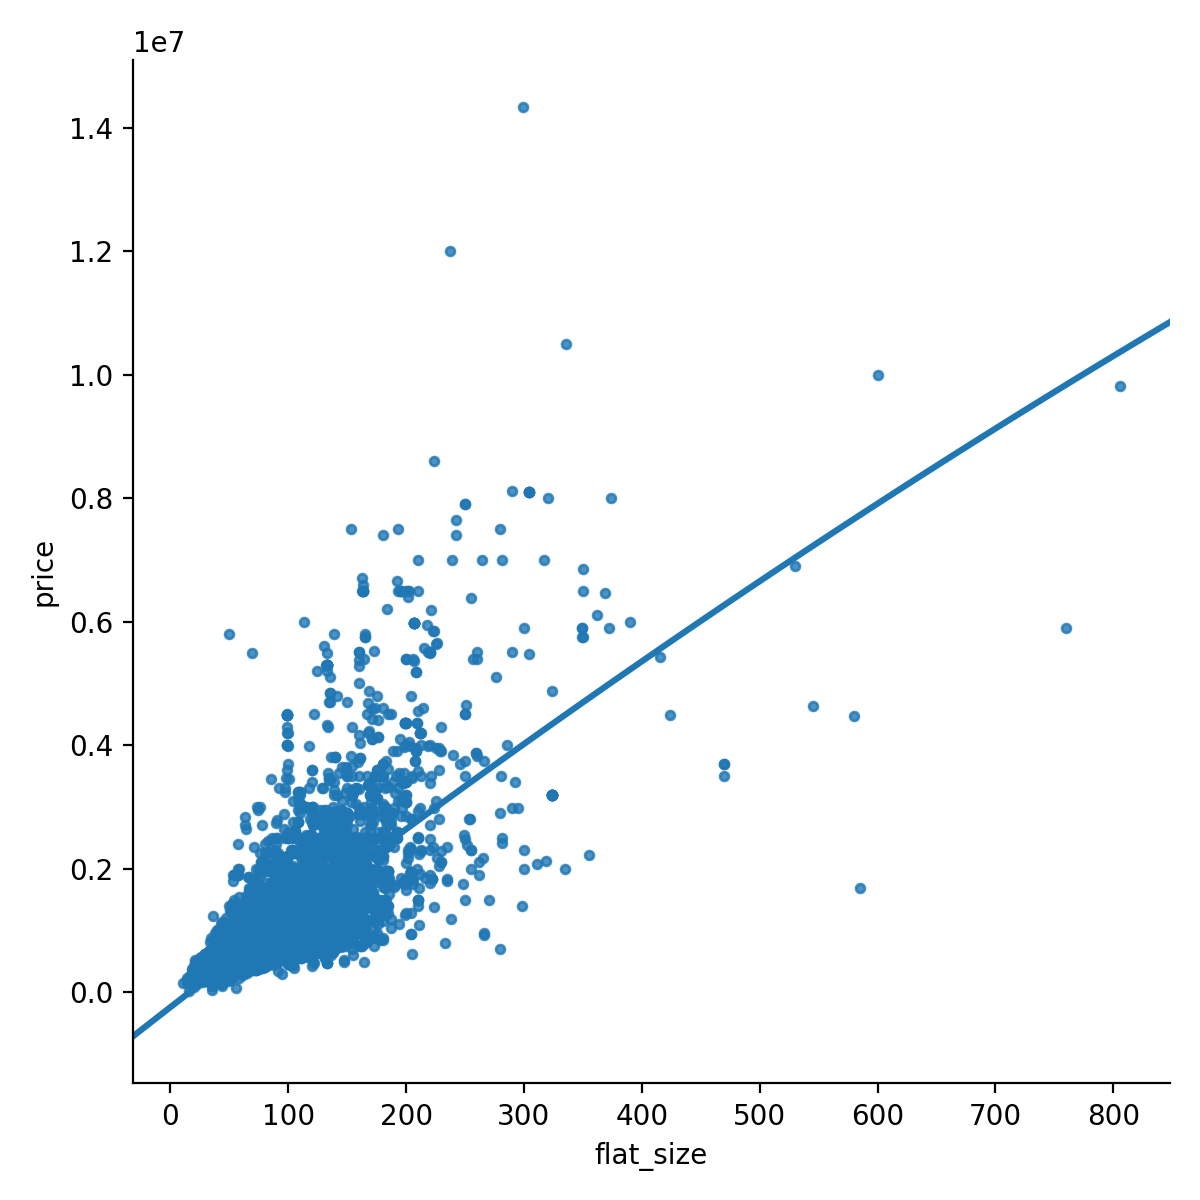

In [34]:
sns.lmplot(x="flat_size", y="price",data=df_data.query("flat_size < 1000"),
           order=2, ci=None, scatter_kws={"s": 10}, height=6);

<IPython.core.display.Javascript object>


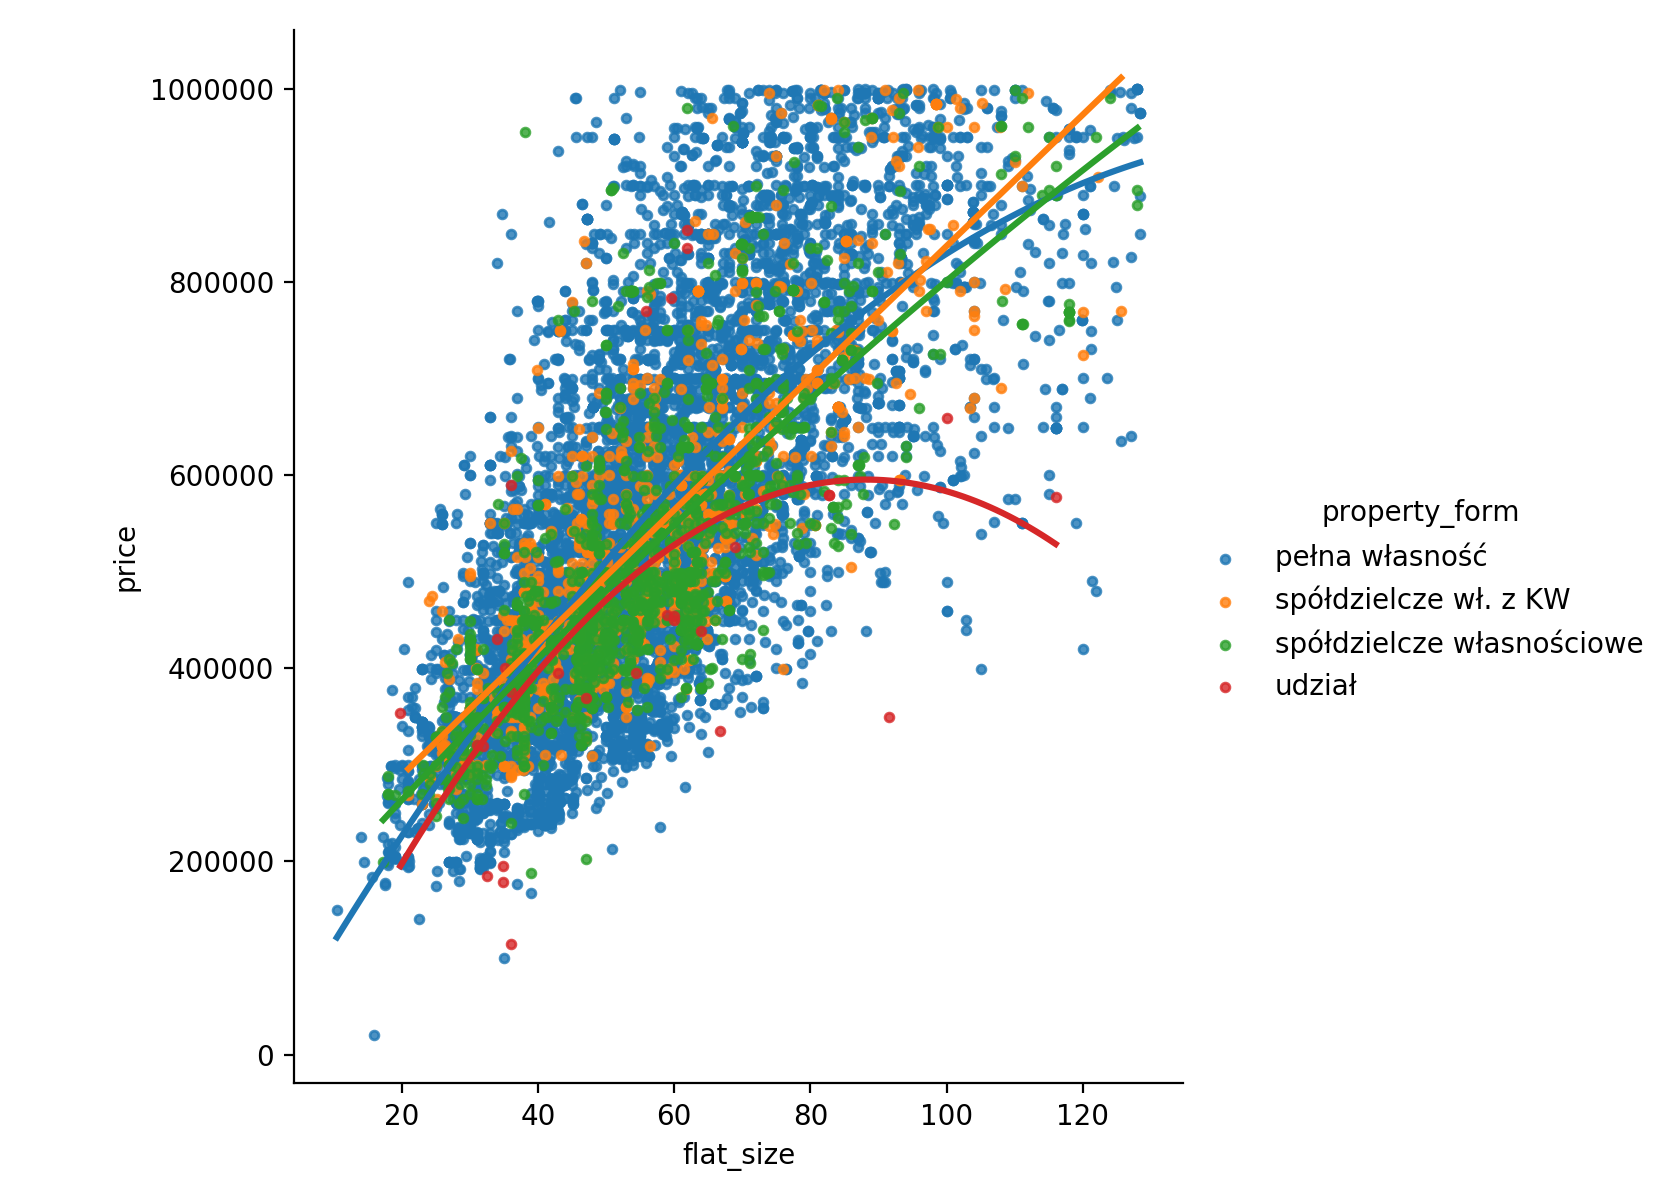

In [35]:
sns.lmplot(x="flat_size", y="price", hue="property_form", data=df_data.query("flat_size < 130 and price < 1000000"),
           order=2, ci=None, scatter_kws={"s": 10}, height=6, truncate=True);

**FILTR**
* usun mieszkania bez ceny 
* ogranicz cene do 1 mln zl  
* ogranicz cene od 10 tys zl
* ogranicz rozmiar mieszkania do 130 m2 .  
* usun mieszkania z forma wlasnosci "udział"

In [36]:
filter_query = "price <= 1000000 and price >= 10000 and flat_size <= 130 and property_form != 'udział'"
df_data_filtered = df_data.dropna(subset = ['price']).query(filter_query)

## train validation test split

In [37]:
partition, labels = train_test_label_split(df_data_filtered,train_val_test_size = [0.7,0.2,0.1])

In [38]:
df_train = df_data_filtered[df_data_filtered['_id'].isin(partition['train'])].reset_index(drop=True)
df_valid = df_data_filtered[df_data_filtered['_id'].isin(partition['validation'])].reset_index(drop=True)
df_test = df_data_filtered[df_data_filtered['_id'].isin(partition['test'])].reset_index(drop=True)

# MODEL

In [39]:
df_train.columns

Index(['_id', 'name', 'location', 'flat_size', 'rooms', 'floor', 'price',
       'price_m2', 'market', 'number_of_floors', 'floor_attic',
       'floor_basement', 'building_type', 'building_material', 'widows_type',
       'heating_type', 'year_of_building', 'finishing_stage', 'rent_price',
       'property_form', 'available_from', 'description', 'additional_info',
       'GC_latitude', 'GC_longitude', 'GC_boundingbox', 'GC_addr_house_number',
       'GC_addr_road', 'GC_addr_neighbourhood', 'GC_addr_suburb',
       'GC_addr_city', 'GC_addr_county', 'GC_addr_state', 'GC_addr_postcode',
       'GC_addr_country', 'GC_addr_country_code', 'url', 'main_url',
       'metro_name'],
      dtype='object')

In [40]:
col_numeric = ['flat_size', 'floor_attic','floor_basement', 'rooms', 'floor', 'rent_price',
               'number_of_floors','year_of_building','GC_latitude','GC_longitude']

col_cat = ['additional_info','market' ,'building_type', 'building_material', 'widows_type',
          'heating_type', 'finishing_stage', 'property_form','metro_name']

cos=['GC_boundingbox', 'GC_addr_house_number', 'GC_addr_road','GC_addr_neighbourhood', 'GC_addr_suburb',
       'GC_addr_city','GC_addr_county', 'GC_addr_state', 'GC_addr_postcode',
       'GC_addr_country', 'GC_addr_country_code', 'url', 'main_url']

col_text = ['name', 'location','description']
col_dat = ['available_from']

In [41]:
#tr = transformColList()
#tr.fit_transform(df_train[col_cat])
#tr.transform(df_valid[col_cat])
#tr.transform(df_test[col_cat])


## lightgbm basic

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from category_encoders import TargetEncoder

import lightgbm as lgb


In [43]:
{'boosting': 'gbdt',
 'lambda_l1': 0.002631009937285191,
 'lambda_l2': 1.5618421536230114,
 'learning_rate': 0.16796848904487346,
 'max_bin': 24477,
 'max_depth': 17,
 'min_child_samples': 49,
 'num_iterations': 220,
 'num_leaves': 147,
 'subsample_for_bin': 6846,
 'zero_as_missing': False}

{'boosting': 'gbdt',
 'lambda_l1': 0.002631009937285191,
 'lambda_l2': 1.5618421536230114,
 'learning_rate': 0.16796848904487346,
 'max_bin': 24477,
 'max_depth': 17,
 'min_child_samples': 49,
 'num_iterations': 220,
 'num_leaves': 147,
 'subsample_for_bin': 6846,
 'zero_as_missing': False}

In [44]:
params = {'colsample_bytree': 0.6624318354159208, #feature_fraction
 'learning_rate': 0.15990411055449805,
 'max_bin': 38712,
 'max_depth': 7,
 'min_child_samples': 84, #min_data_in_leaf
 'min_child_weight': 6, #min_sum_hessian_in_leaf
 'n_estimators': 206, #num_iterations
 'num_leaves': 159,
 'reg_alpha': 3.960667919705787e-06, #lambda_l1
 'reg_lambda': 499.85995495490215, #lambda_l2
 'subsample': 0.9022680042341511, #bagging_fraction
 'subsample_for_bin': 144116, #bin_construct_sample_cnt
 'subsample_freq': 0 #bagging_freq
         } 

In [45]:
seed = 666

pipe_lgb = make_pipeline(
    ColumnTransformer([
        ('cat', transformColList(),col_cat),
        ('num', PassThroughOrReplace(),col_numeric),
        ('txt_dscr', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1, 3), 
                               max_features=3000, 
                               dtype=np.float32,
                               use_idf=True),'description'),
        ('txt_loc', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1,1), 
                               max_features=500, 
                               dtype=np.float32,
                               binary = True, 
                               use_idf=False),'location')
    ]),
    lgb.LGBMRegressor(**params)
    )

In [46]:
%%time
save = pipe_lgb.fit(df_train, df_train.price.tolist())

CPU times: user 1min 15s, sys: 4.63 s, total: 1min 20s
Wall time: 1min 1s


In [47]:
#first pipe
y_pred = pipe_lgb.predict(df_train)
r2 = r2_score(df_train.price, y_pred)
med_abs_err = median_absolute_error(df_train.price, y_pred)
mean_abs_err = mean_absolute_error(df_train.price, y_pred)

print("Train r2 score {}, median absolute error {}, mean absolute error {}".format(round(r2,4),int(med_abs_err), int(mean_abs_err)))
y_pred = pipe_lgb.predict(df_valid)
r2 = r2_score(df_valid.price, y_pred)
med_abs_err = median_absolute_error(df_valid.price, y_pred)
mean_abs_err = mean_absolute_error(df_valid.price, y_pred)

print("Validation r2 score {}, median absolute error {}, mean absolute error {}".format(round(r2,4),int(med_abs_err), int(mean_abs_err)))


Train r2 score 0.927, median absolute error 24052, mean absolute error 34809
Validation r2 score 0.893, median absolute error 29687, mean absolute error 42860


Plotting feature importances...


<IPython.core.display.Javascript object>


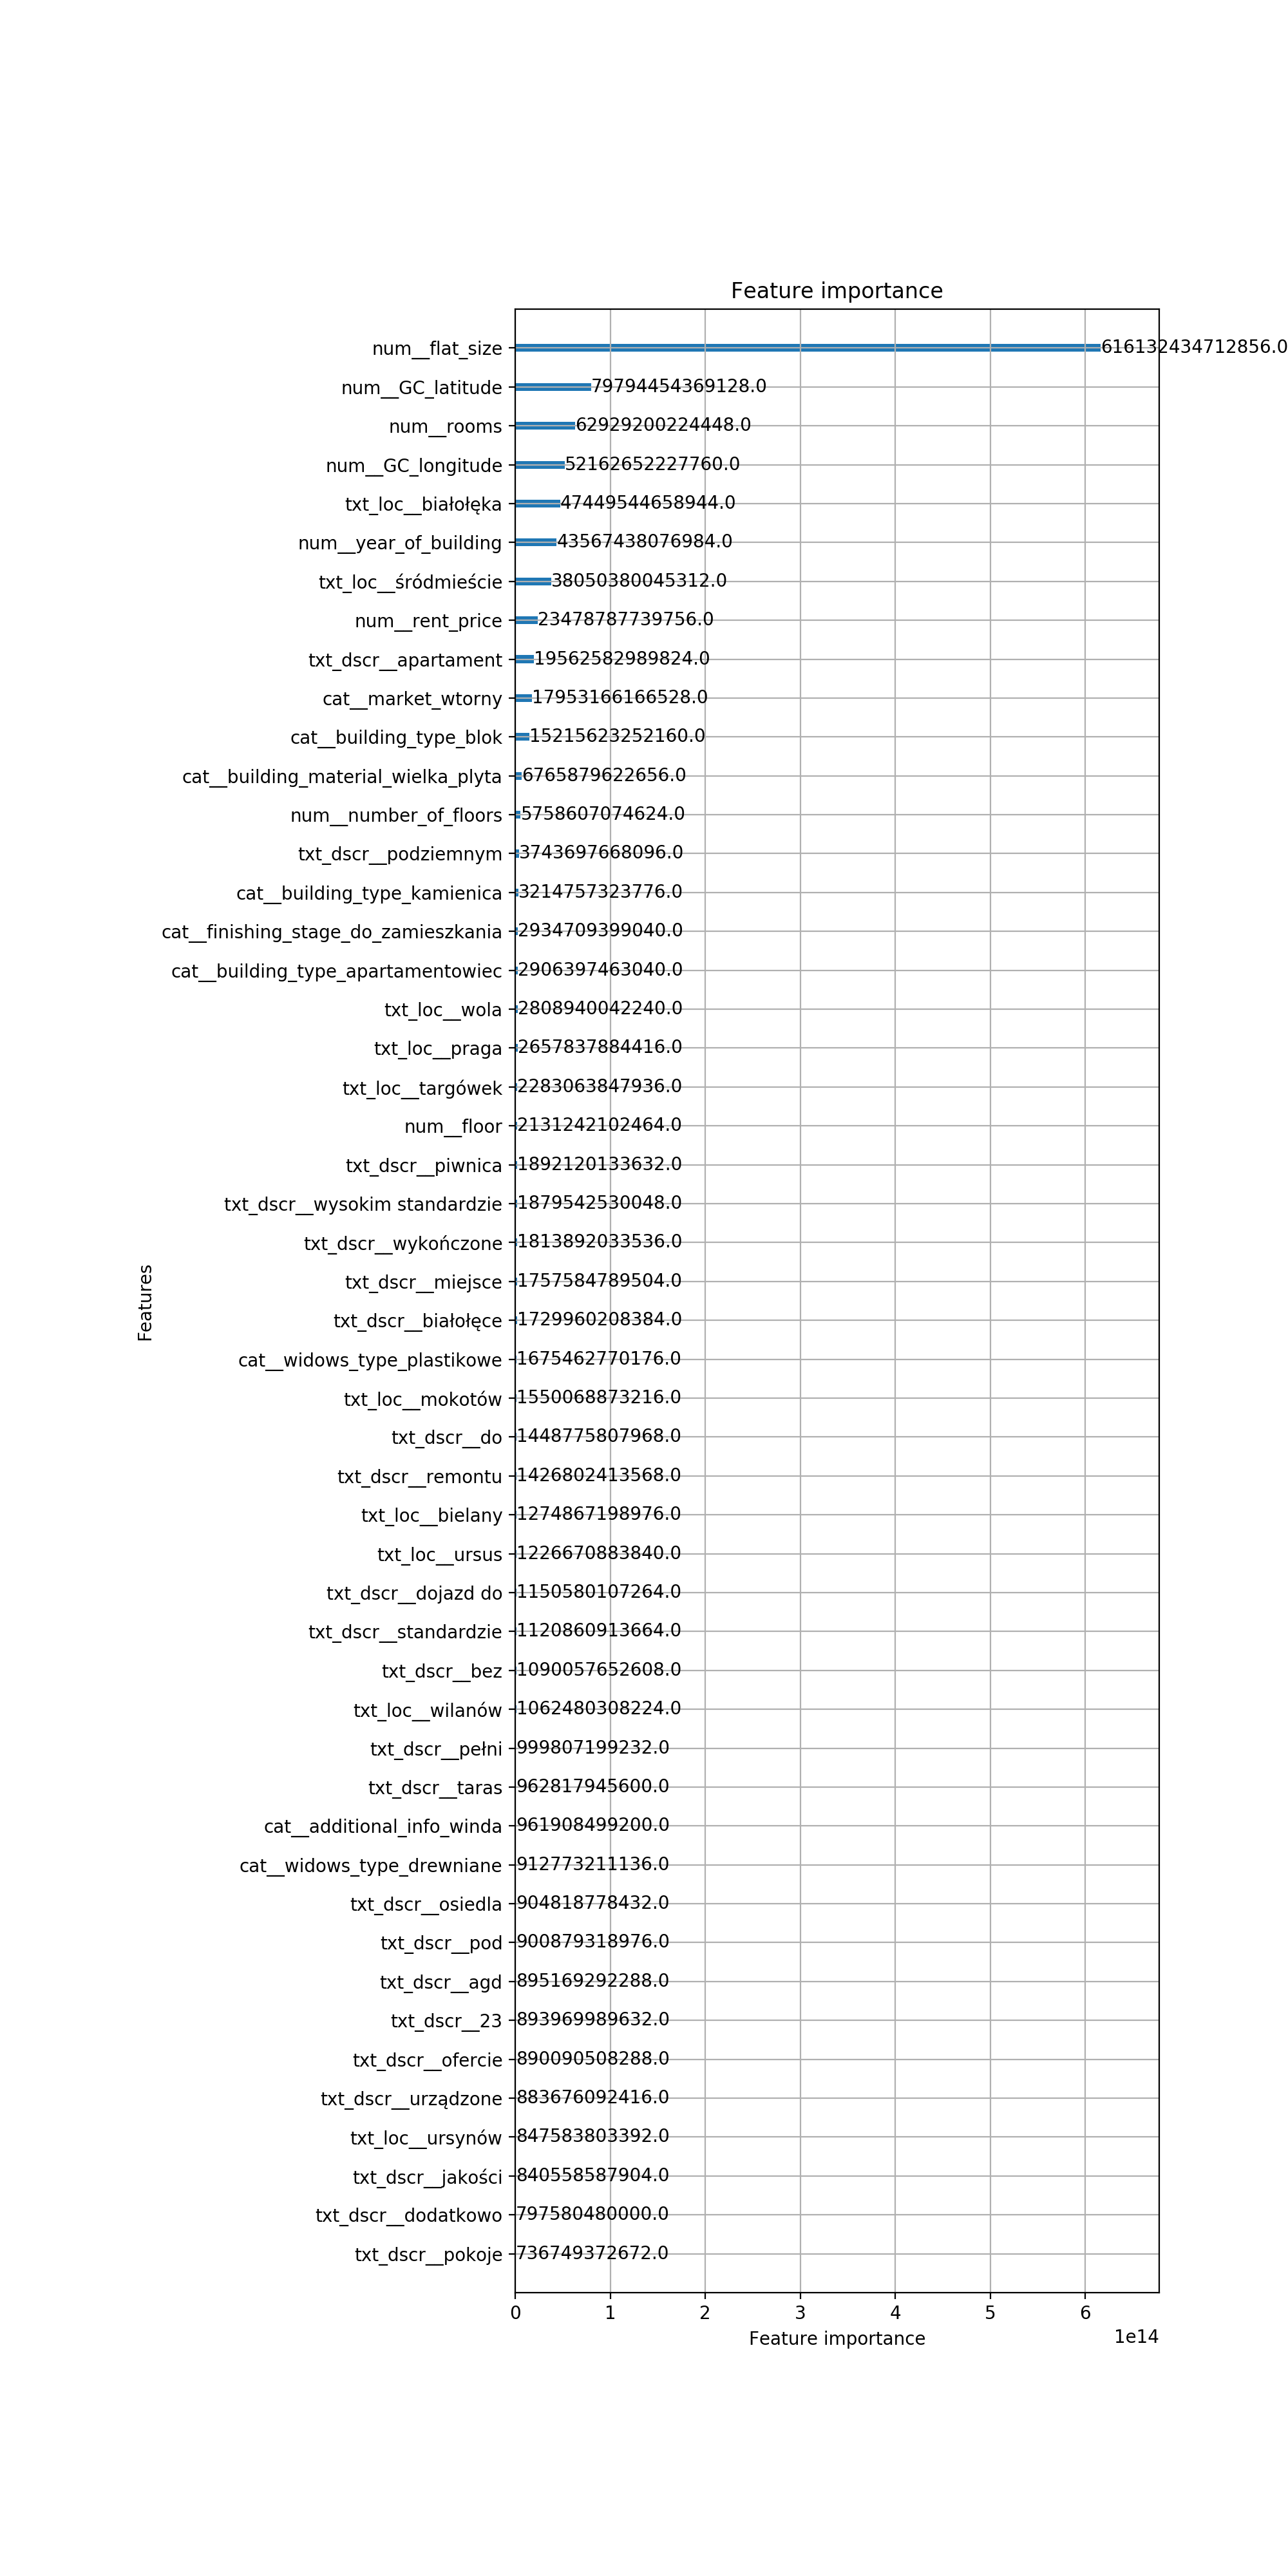

In [48]:
print('Plotting feature importances...')
def names(): return pipe_lgb.named_steps['columntransformer'].get_feature_names()
pipe_lgb.named_steps['lgbmregressor'].booster_.feature_name = names
fig, ax = plt.subplots(figsize=(10,20))
fig.subplots_adjust(left=0.4)
lgb.plot_importance(pipe_lgb.named_steps['lgbmregressor'], max_num_features=50, ax=ax, importance_type = 'gain')
plt.yticks(fontsize=10)
plt.show()

In [49]:
df_valid_x = df_valid.copy()
df_valid_x['y_pred'] = [np.int32(i) for i in y_pred]
wyn = df_valid_x.assign(y_diff= lambda x: x['price']-x['y_pred']).sort_values('y_diff')

<IPython.core.display.Javascript object>


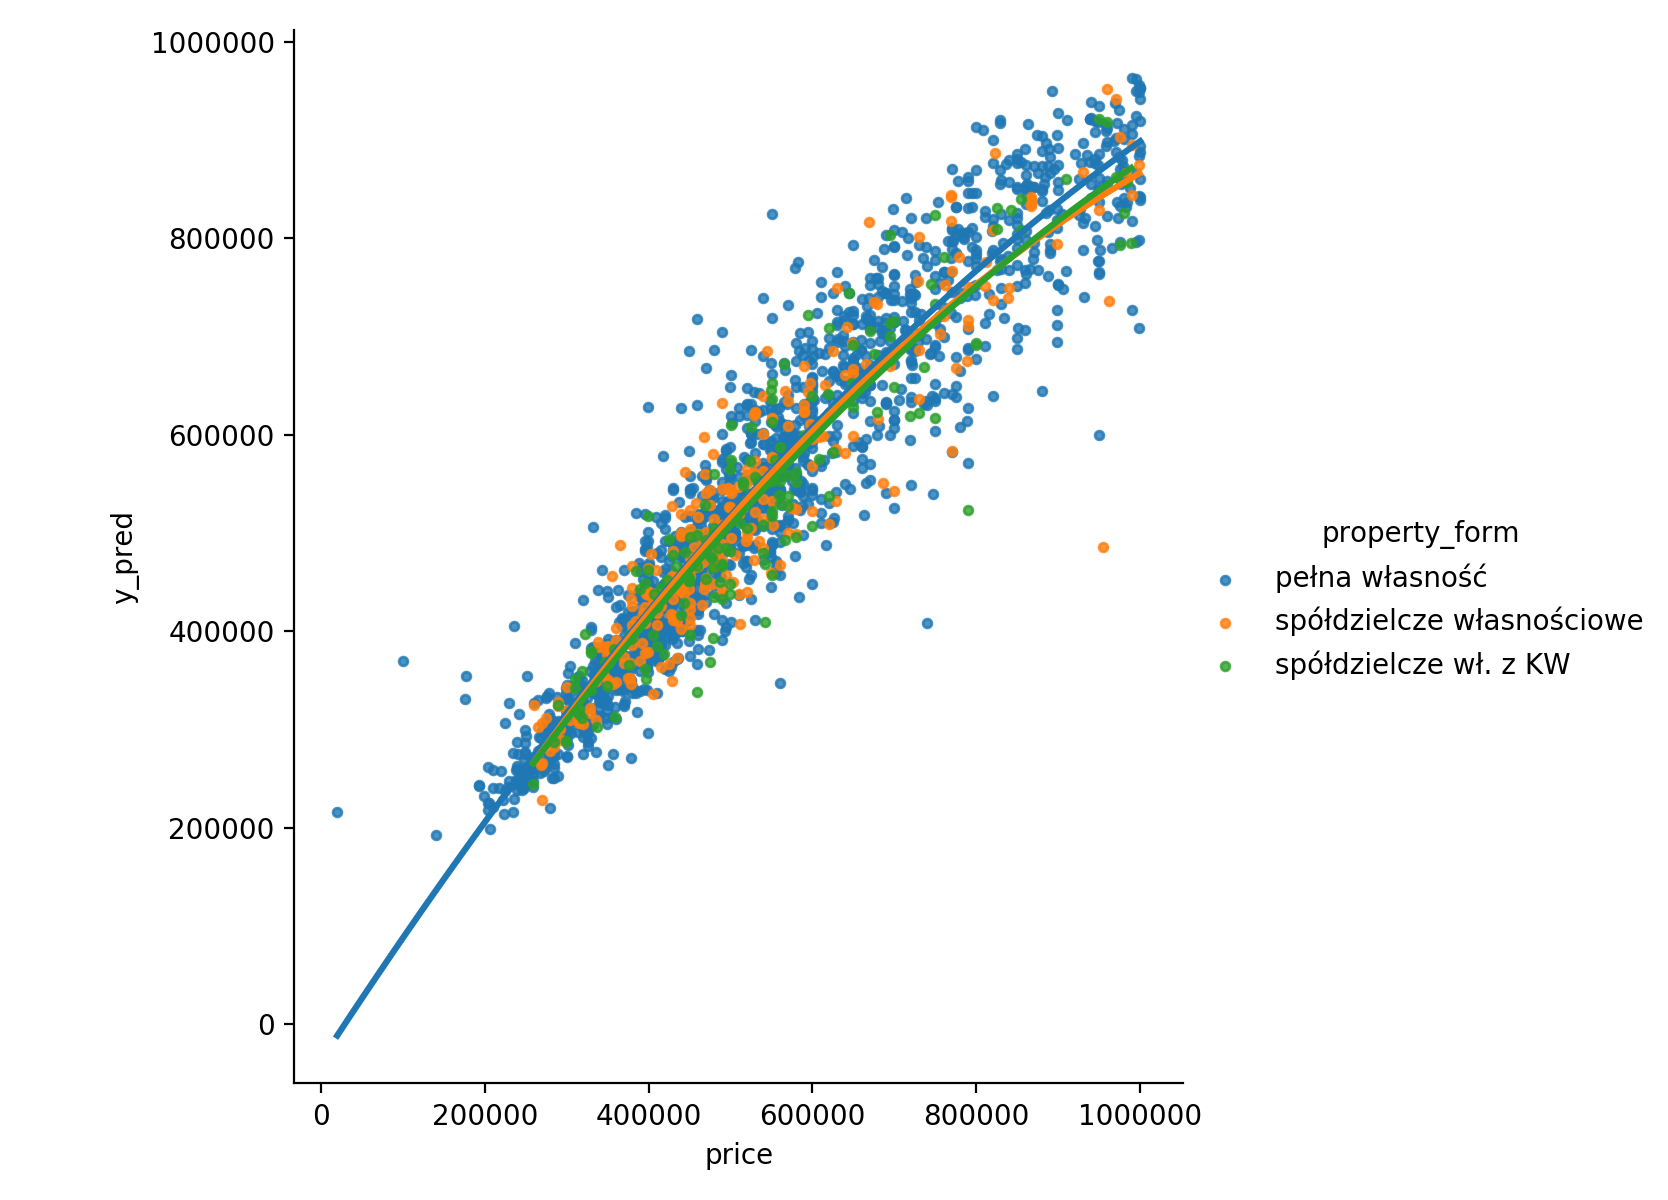

In [50]:
sns.lmplot(x="price", y="y_pred",hue="property_form",
           data=wyn,order=2, ci=None, scatter_kws={"s": 10}, height=6, truncate=True);

## lightgbm tune

In [215]:
import pprint
from time import time

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Model selection
from sklearn.model_selection import StratifiedKFold, GroupShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_log_error


# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has


In [216]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

import lightgbm as lgb
import joblib

In [217]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [218]:
def onstep(res):
    """
    https://scikit-optimize.github.io/notebooks/interruptible-optimization.html
    """
    global counter

    x0 = res.x_iters   # List of input points
    y0 = res.func_vals # Evaluation of input points
    print('{}, Current score: {}, Best score {}'.format(counter, round(res.func_vals[-1],3), round(res.fun,3)))
    joblib.dump((x0, y0), 'checkpoint.pkl') # Saving a checkpoint to disk
    counter += 1
    


In [219]:
# Converting average precision score into a scorer suitable for model selection
avg_absolute_error = make_scorer(mean_absolute_error, greater_is_better=False)
avg_mean_squared_log_error = make_scorer(mean_squared_log_error, greater_is_better=False)
avg_r2_score = make_scorer(r2_score, greater_is_better=True)

In [105]:
params = {'colsample_bytree': 0.6624318354159208, #feature_fraction
 'learning_rate': 0.15990411055449805,
 'max_bin': 38712,
 'max_depth': 7,
 'min_child_samples': 84, #min_data_in_leaf
 'min_child_weight': 6, #min_sum_hessian_in_leaf
 'n_estimators': 206, #num_iterations
 'num_leaves': 159,
 'reg_alpha': 3.960667919705787e-06, #lambda_l1
 'reg_lambda': 499.85995495490215, #lambda_l2
 'scale_pos_weight': 0.0005610330855825128, #DEL its for clasification
 'subsample': 0.9022680042341511, #bagging_fraction
 'subsample_for_bin': 144116, #bin_construct_sample_cnt
 'subsample_freq': 0 #bagging_freq
         } 


In [ ]:
search_spaces = {
        'learning_rate': Real(0.01, 0.6, 'log-uniform'),
        'num_leaves': Integer(2, 500),
        'max_depth': Integer(0, 300),
        'min_child_samples': Integer(0, 200), # minimal number of data in one leaf
        'max_bin': Integer(100, 50000), # max number of bins that feature values will be bucketed
        'subsample': Real(0.5, 1.0, 'uniform'),
        'subsample_freq': Integer(0, 10), # bagging fraction
        'colsample_bytree': Real(0.3, 1.0, 'uniform'), # enabler of bagging fraction
        'min_child_weight': Integer(0, 10), # minimal number of data in one leaf.
        'subsample_for_bin': Integer(1000, 20000), # number of data that sampled for histogram bins
        'reg_lambda': Real(1e-9, 300, 'log-uniform'), # L2 regularization
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'), # L1 regularization
        'n_estimators': Integer(10, 10000)        
        }

In [253]:
search_spaces = {'objective': Categorical(categories=['regression','regression_l1','huber','quantile']),
                 'n_estimators': Integer(10, 500), #number of boosting iterations, 
                 'learning_rate': Real(0.01, 0.6, 'log-uniform'),
                 'num_leaves': Integer(2, 300), #max number of leaves in one tree
                 'max_depth': Integer(0, 20), #limit the max depth for tree model. This is used to deal with over-fitting when #data is small
                 'min_child_samples': Integer(0, 200), # minimal number of data in one leaf. Can be used to deal with over-fitting
                 'max_bin': Integer(100, 30000), # max number of bins that feature values will be bucketed, 
                 'subsample': Real(0.4, 1.0, 'uniform'),
                 'subsample_freq': Integer(0, 10), # bagging fraction
                 'colsample_bytree': Real(0.4, 1.0, 'uniform'), # enabler of bagging fraction
                 'min_child_weight': Integer(0, 10), # minimal sum hessian in one leaf
                 'subsample_for_bin': Integer(3000, 10000), # number of data that sampled for histogram bins                 
                 'reg_lambda': Real(1e-9, 300, 'log-uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 1.0, 'log-uniform'), # L1 regularization
                 'zero_as_missing': Categorical(categories=[True])
              }

In [254]:
regresor = lgb.LGBMRegressor()

In [255]:
%%time
train_prep = pipe_lgb.named_steps['columntransformer'].transform(df_train) 

CPU times: user 8.53 s, sys: 249 ms, total: 8.78 s
Wall time: 9.44 s


In [262]:
opt = BayesSearchCV(regresor,
                    search_spaces,
                    scoring=avg_absolute_error,
                    cv=3,
                    n_iter=100,
                    n_jobs=-1,
                    return_train_score=False,
                    refit=False,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=666)

In [ ]:
counter = 0
best_params = report_perf(opt, train_prep, df_train.price.tolist(),'LightGBM', 
                          callbacks=[onstep,DeadlineStopper(60*80)])
#VerboseCallback(1)

0, Current score: 112463.28, Best score 112463.28
1, Current score: 149849.571, Best score 112463.28
2, Current score: 46290.833, Best score 46290.833
3, Current score: 146516.589, Best score 46290.833
4, Current score: 149807.81, Best score 46290.833
5, Current score: 82674.895, Best score 46290.833
6, Current score: 54746.648, Best score 46290.833
7, Current score: 80359.148, Best score 46290.833
8, Current score: 48482.37, Best score 46290.833
9, Current score: 47338.415, Best score 46290.833
10, Current score: 48726.044, Best score 46290.833
11, Current score: 46622.44, Best score 46290.833
12, Current score: 46532.841, Best score 46290.833


### GENERATOR

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    """
    Generates data for Keras
    https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """
    def __init__(self, list_IDs, labels, raw_json, batch_size=32, shuffle=True):
        'Initialization'
        self.list_IDs = list_IDs
        self.labels = labels
        self.raw_json = raw_json
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        #self.dim = dim
        #self.n_channels = n_channels
        #self.n_classes = n_classes

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def json2numpy(self):
        
        
            
    #def __data_generation(self, list_IDs_temp):
    def data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [ ]:
dg = DataGenerator(list_IDs = ID_list, labels = labels, raw_json = raw_data)
dg.data_generation(ID_list[:10])

In [ ]:
# load data frame

def load_data(file_name_list, file_path):
    
    _tmp_list = [None for i in range(len(file_name_list))]
    
    for i,file in enumerate(file_name_list):
        
        # LOAD DATA
        _tmp = helpers.scraper.read_bson_local(file_path, file)
        _tmp = helpers.scraper.dict_except(_tmp,['img_gallery_strimg','gallery'])
        
        # PUT DATA INTO COLUMNS
        _tmp['_id'] = file
        _tmp['GC_latitude'] = _tmp['geo_coordinates']['latitude']
        _tmp['GC_llongitude'] = _tmp['geo_coordinates']['longitude']
        _tmp['GC_boundingbox'] = _tmp['geo_address_coordin']['@boundingbox']
        _tmp['GC_addr_house_number'] = _tmp['geo_address_text']['house_number'] if 'house_number' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_road'] = _tmp['geo_address_text']['road'] if 'road' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_neighbourhood'] = _tmp['geo_address_text']['neighbourhood'] if 'neighbourhood' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_suburb'] = _tmp['geo_address_text']['suburb'] if 'suburb' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_city'] = _tmp['geo_address_text']['city'] if 'city' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_county'] = _tmp['geo_address_text']['county'] if 'country' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_state'] = _tmp['geo_address_text']['state'] if 'state' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_postcode'] = _tmp['geo_address_text']['postcode'] if 'postcode' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_country'] = _tmp['geo_address_text']['country'] if 'country' in _tmp['geo_address_text'] else None
        _tmp['GC_addr_country_code'] = _tmp['geo_address_text']['country_code'] if 'country_code' in _tmp['geo_address_text'] else None
        _ = _tmp.pop('geo_coordinates')
        _ = _tmp.pop('geo_address_coordin')
        _ = _tmp.pop('price_per_square')

        
        # MODIFY DATA
        _tmp['flat_size'] = helpers.scraper.digits_from_str(_tmp['flat_size']) if _tmp['flat_size'] is not None else None
        _tmp['price'] = helpers.scraper.digits_from_str(_tmp['price']) if _tmp['price'] is not None else None
        _tmp['price_m2'] = helpers.scraper.digits_from_str(_tmp['price_m2']) if _tmp['price_m2'] is not None else None
        _tmp['rooms'] = int(helpers.scraper.digits_from_str(_tmp['rooms'])) if _tmp['rooms'] is not None else None
        _tmp['floor_attic'] = 1 if _tmp['floor']=='poddasze' else 0
        _tmp['floor_basement'] = 1 if _tmp['floor']=='suterena' else 0
        _tmp['floor'] = np.float32(helpers.scraper.convert_floor(_tmp['floor'])) if isinstance(_tmp['floor'], (str)) else None
        _tmp['number_of_floors'] = np.float32(_tmp['number_of_floors']) if isinstance(_tmp['number_of_floors'], (str)) else None
        _tmp['year_of_building'] = np.float32(_tmp['year_of_building']) if isinstance(_tmp['year_of_building'], (str)) else None
        _tmp['rent_price'] = helpers.scraper.digits_from_str(_tmp['rent_price']) if _tmp['rent_price'] is not None else None
        
        # SAVE TO LIST
        _tmp_list[i] = _tmp
        
        columns = ['offer_id','tracking_id','name','location','flat_size', 'rooms','floor','price',
                'price_m2', 'market', 'number_of_floors', 'floor_attic','floor_basement','building_type', 
                'building_material', 'widows_type', 'heating_type', 'year_of_building','finishing_stage', 
                'rent_price', 'property_form', 'available_from','description','additional_info',
                'GC_latitude','GC_llongitude', 'GC_boundingbox', 'GC_addr_house_number','GC_addr_road', 
                'GC_addr_neighbourhood', 'GC_addr_suburb','GC_addr_city', 'GC_addr_county', 'GC_addr_state', 
                'GC_addr_postcode','GC_addr_country', 'GC_addr_country_code','url','main_url']
    
    return pd.DataFrame(_tmp_list)[columns]


# Load Data Frame

In [ ]:
data_df = load_data(file_list,LOCAL_DATA_PATH)


In [ ]:
feather.write_dataframe(data_df, os.path.join(LOCAL_DATA_PATH_PREP,'train_data.feather'))

# Load Images

In [ ]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import numpy as np

In [ ]:
%%time

def load_data(file_name_list, file_path, img_size = (224, 224)):
    
    _tmp_list = [None for i in range(len(file_name_list))]
    
    for i,file in enumerate(file_name_list):

        # LOAD DATA
        _tmp = helpers.scraper.read_bson_local(file_path, file)
        _tmp = helpers.scraper.dict_except(_tmp,include_keys=['price','img_gallery_strimg'])
        
        # PUT DATA INTO COLUMNS
        _tmp['_id'] = file
        _tmp['price'] = helpers.scraper.digits_from_str(_tmp['price']) if _tmp['price'] is not None else None
        _tmp['photo_1'] = helpers.scraper.open_img_from_str(_tmp['img_gallery_strimg'][0]).resize(img_size) if len(_tmp['img_gallery_strimg'])>0 else None
        _tmp['photo_2'] = helpers.scraper.open_img_from_str(_tmp['img_gallery_strimg'][1]).resize(img_size) if len(_tmp['img_gallery_strimg'])>1 is not None else None
        _tmp['photo_3'] = helpers.scraper.open_img_from_str(_tmp['img_gallery_strimg'][2]).resize(img_size) if len(_tmp['img_gallery_strimg'])>2 is not None else None
        _ = _tmp.pop('img_gallery_strimg')
        
        # SAVE TO LIST
        _tmp_list[i] = _tmp
        
    return _tmp_list

photo = load_data(file_list,LOCAL_DATA_PATH)


In [ ]:
name = []
price = []

for i in photo:
    name += [i['_id']]
    price += [i['price']]
    

In [ ]:
name = np.array(name).reshape(-1,1)
price = np.array(price).reshape(-1,1)

In [ ]:
%%time

array_photo_1 = []
array_photo_2 = []
array_photo_3 = []

for i in photo:
    array_photo_1 += [image.img_to_array(i['photo_1']) if i['photo_1'] is not None else np.zeros((224, 224, 3))]
    array_photo_2 += [image.img_to_array(i['photo_2']) if i['photo_2'] is not None else np.zeros((224, 224, 3))]
    array_photo_3 += [image.img_to_array(i['photo_3']) if i['photo_3'] is not None else np.zeros((224, 224, 3))]


In [ ]:
import gc

del(photo)
gc.collect()


In [ ]:
array_photo_1 = np.concatenate(array_photo_1).reshape(-1,224,224,3)

In [ ]:
array_photo_2 = np.concatenate(array_photo_2).reshape(-1,224,224,3)

In [ ]:
array_photo_3 = np.concatenate(array_photo_3).reshape(-1,224,224,3)

In [ ]:
import gc
gc.collect()

https://keras.io/getting-started/faq/#how-can-i-use-hdf5-inputs-with-keras    
http://tdeboissiere.github.io/h5py-vs-npz.html

%%time

with h5py.File(os.path.join(LOCAL_DATA_PATH_PREP,'array_photo.h5'), "w") as hf:
    dset = hf.create_dataset("array_photo_1", data=array_photo_1, compression="gzip")
    dset = hf.create_dataset("array_photo_2", data=array_photo_2, compression="gzip")
    dset = hf.create_dataset("array_photo_3", data=array_photo_3, compression="gzip")
    dset = hf.create_dataset("name", data=name, compression="gzip", compression_opts=9)
    dset = hf.create_dataset("price", data=price, compression="gzip", compression_opts=9)

In [ ]:
np.savez_compressed(os.path.join(LOCAL_DATA_PATH_PREP,'array_photo'), 
                    a1=array_photo_1, a2=array_photo_2, a3=array_photo_3)